In [1]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import glob
import re
import os
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import albumentations as A

In [2]:
from torchvision import transforms
import torchvision.datasets as datasets

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
path2img = "/media/brats/DRIVE1/akansh/lung-seg/data/images/"
path2mask = "/media/brats/DRIVE1/akansh/lung-seg/data/masks/"

In [9]:
class LungDataset(Dataset):
    
    def __init__(self, img_dir, mask_dir, transform = None):
        
        self.img_dir = [os.path.join(img_dir,i) for i in os.listdir(img_dir) if i.endswith('png')]
        self.img_dir.sort()
        self.mask_dir = None
        if mask_dir is not None:
            self.mask_dir = [os.path.join(mask_dir,i) for i in os.listdir(mask_dir) if i.endswith('png')]
            self.mask_dir.sort()
        self.transforms = transform
        self.norm_transform = A.Normalize()

    def __len__(self):
        return len(self.img_dir)
    
    def __getitem__(self,idx):
        img = cv2.imread(self.img_dir[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.mask_dir is not None:
            mask = cv2.imread(self.mask_dir[idx])[:, :, 0]
            mask = np.clip(mask, 0, 1).astype("float32")
            augmented = self.transforms(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
#             im = self.post_transforms(img)
            return  torch.tensor(img), torch.FloatTensor(mask)
        
        else:
            augmented = self.transforms(image=img)
            img = augmented['image']
            im = self.post_transforms(img)
            return torch.tensor(img)  

In [6]:
def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0,0,0
    
    for data,_ in tqdm(loader):
        channels_sum += torch.mean(data, dim = [0,2,3])
        channels_squared_sum += torch.mean(data**2, dim = [0,2,3])
        num_batches += 1
        
    mean = channels_sum/num_batches
    std = (channels_squared_sum/num_batches - mean**2)**0.5
    
    return mean, std

class LungDataset(Dataset):
    
    def __init__(self, img_dir, mask_dir, transforms = None):
        
        self.img_dir = [os.path.join(img_dir,i) for i in os.listdir(img_dir) if i.endswith('png')]
        self.img_dir.sort()
        self.mask_dir = None
        if mask_dir is not None:
            self.mask_dir = [os.path.join(mask_dir,i) for i in os.listdir(mask_dir) if i.endswith('png')]
            self.mask_dir.sort()
        self.transforms = transforms        
    def __len__(self):
        return len(self.img_dir)
    
    def __getitem__(self,idx):
        img = cv2.imread(self.img_dir[idx], cv2.IMREAD_GRAYSCALE)
        if self.mask_dir is not None:
            mask = cv2.imread(self.mask_dir[idx], cv2.IMREAD_GRAYSCALE)
            mask = np.clip(mask, 0, 1).astype("float32")
            augmented = self.transforms(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
            return torch.tensor(img), torch.FloatTensor(mask)
        
        else:
#             augmented = self.transforms(image=img)
#             img = augmented['image']
            return self.transforms(img), 0  
trainset = LungDataset(img_dir = path2img, mask_dir = None, transforms = transforms.ToTensor())


train_loader = DataLoader(dataset = trainset, batch_size = 64, shuffle = True)

mean, std = get_mean_std(train_loader)
print(f"Mean: {mean}, STD: {std}")

  0%|          | 0/3 [00:00<?, ?it/s]

Mean: tensor([0.4411]), STD: tensor([0.3336])


In [7]:
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Rotate((-30,30), p = 0.5),
    A.ElasticTransform(p=0.5, alpha=1, sigma=50, alpha_affine=10),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.3),
    A.GridDistortion(p=0.5),
    A.OpticalDistortion(distort_limit=0.8, shift_limit=0.6, p=1),
    A.RandomSizedCrop(min_max_height=(150, 200), height=224, width=224, p=0.5),
    A.CLAHE(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p = 0.5),
        ])


test_transforms = A.Compose([
    A.Rotate(0, p = 1)
        ])

In [10]:
lung_data_1 = LungDataset(img_dir = path2img, mask_dir = path2mask, transform = train_transforms)
lung_data_2 = LungDataset(img_dir = path2img, mask_dir = path2mask, transform = test_transforms)

In [14]:
for x, y in lung_data_1:
    print(x.shape)
    print(y)
    break

torch.Size([224, 224, 3])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


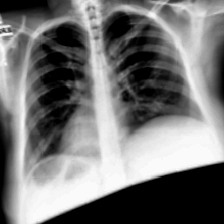

In [19]:
Image.fromarray(x.numpy())

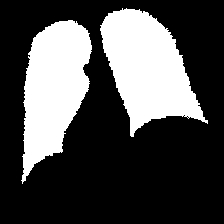

In [29]:
Image.fromarray(y.numpy().astype('bool'))

In [165]:
len(lung_data_1)

138

### Spliting the dataset

In [30]:
from sklearn.model_selection import ShuffleSplit

In [31]:
sss = ShuffleSplit(n_splits=1, test_size=0.1, random_state=0)

In [32]:
indices=range(len(lung_data_1))
for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print("-"*10)
    print(len(val_index))

124
----------
14


In [36]:
from torch.utils.data import Subset
train_ds=Subset(lung_data_1,train_index)
print(len(train_ds))
print("-"*10)

val_ds=Subset(lung_data_2,val_index)
print(len(val_ds))

124
----------
14


In [37]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)

In [38]:
for img_b, mask_b in train_dl:
    print(img_b.shape,img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break

torch.Size([8, 224, 224, 3]) torch.uint8
torch.Size([8, 224, 224]) torch.float32


### Model

In [11]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):

    def __init__(self, n_classes=1):
        super().__init__()
        
        self.base_model = torchvision.models.resnet50(pretrained=False)
        
        self.base_layers = list(self.base_model.children())                
        
        self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])        
        self.layer1_1x1 = convrelu(256, 256, 1, 0)       
        self.layer2 = self.base_layers[5]         
        self.layer2_1x1 = convrelu(512, 512, 1, 0)  
        self.layer3 = self.base_layers[6]         
        self.layer3_1x1 = convrelu(1024, 1024, 1, 0)  
        self.layer4 = self.base_layers[7] 
        self.layer4_1x1 = convrelu(2048, 2048, 1, 0)  
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu(1024 + 2048, 1024, 3, 1)
        self.conv_up2 = convrelu(512 + 1024, 512, 3, 1)
        self.conv_up1 = convrelu(256 + 512, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 64, 3, 1)
        
        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(128, 64, 3, 1)
        
        self.conv_last = nn.Conv2d(64, n_classes, 1)
        
    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)
        
        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2) 
        layer4 = self.layer4(layer3)
        
        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)
        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)
        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)
        
        out = torch.sigmoid(self.conv_last(x))  

        return out

In [12]:
model = ResNetUNet().to('cuda');

In [58]:
def jaccard_coef_metric(inputs, target, eps=1e-7):
    intersection = (target * inputs).sum()
    union = (target.sum() + inputs.sum()) - intersection + eps

    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return (intersection + eps) / union

def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

## Loss

def dice_coef_loss(inputs, target):
    smooth = 1.0
    intersection = 2.0 * ((target * inputs).sum()) + smooth
    union = target.sum() + inputs.sum() + smooth

    return 1 - (intersection / union)


def bce_dice_loss(inputs, target):
    dicescore = dice_coef_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

In [67]:
def train_one_epoch(model, optimizer, lr_scheduler, metric,
                    dataloader, epoch, criterion=bce_dice_loss):
    
    print("Start Train ...")
    model.train()

    losses = []
    accur = []

    for data, target in tqdm(dataloader):

        data = data.permute(0,3,1,2).to(DEVICE).float()
        targets = target.unsqueeze(1).to(DEVICE)

        outputs = model(data)

        out_cut = np.copy(outputs.data.cpu().numpy())
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0

        train_dice = metric(out_cut, targets.data.cpu().numpy())

        loss = criterion(outputs, targets)

        losses.append(loss.item())
        accur.append(train_dice)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if lr_scheduler is not None:
        lr_scheduler.step()

    lr = lr_scheduler.get_last_lr()[0]
    print("Epoch [%d]" % (epoch),
          "Mean loss on train:", np.array(losses).mean(), 
          "Mean DICE on train:", np.array(accur).mean(), 
          "Learning Rate:", lr)

    
    return np.array(losses).mean(), np.array(accur).mean(), lr


def val_epoch(model, metric, dataloader, epoch, threshold=0.5):
    
    print("Start Validation ...")
    model.eval()
    
    val_acc = []

    with torch.no_grad():
        for data, targets in tqdm(dataloader):

            data = data.permute(0,3,1,2).to(DEVICE).float()
            targets = targets.unsqueeze(1).to(DEVICE)

            outputs = model(data)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            val_dice = metric(out_cut, targets.data.cpu().numpy())
            val_acc.append(val_dice)

        print("Epoch:  " + str(epoch) + "  Threshold:  " + str(threshold)\
              + " Mean Validation DICE Score:", np.array(val_acc).mean())
        
        return  np.array(val_acc).mean()

In [68]:
for param in model.parameters():
    param.requires_grad = True
    
params = [p for p in model.parameters() if p.requires_grad]

stage_epoch = [12, 8, 5]#[20, 15, 10]
stage_optimizer = [
    torch.optim.Adamax(params, lr=0.0002),
    torch.optim.SGD(params, lr=0.00009, momentum=0.9),
    torch.optim.Adam(params, lr=0.00005),
]

stage_scheduler = [
    torch.optim.lr_scheduler.CosineAnnealingLR(stage_optimizer[0], 4, 1e-6),
    torch.optim.lr_scheduler.CyclicLR(stage_optimizer[1], base_lr=1e-5, max_lr=2e-4),
    torch.optim.lr_scheduler.CosineAnnealingLR(stage_optimizer[2], 4, 1e-6),
]

In [69]:
DEVICE = 'cuda'
weights_dir = "weights"
if os.path.exists(weights_dir) == False:
    os.mkdir(weights_dir)


loss_history = []
train_dice_history = []
val_dice_history = []
lr_history = []

for k, (num_epochs, optimizer, lr_scheduler) in enumerate(zip(stage_epoch, stage_optimizer, stage_scheduler)):
    for epoch in range(num_epochs):
        
        
        loss, train_dice, lr = train_one_epoch(model, optimizer, lr_scheduler, 
                                               dice_coef_metric, train_dl, epoch)
    
        val_dice = val_epoch(model, dice_coef_metric, val_dl, epoch)
        
        
        # train history
        loss_history.append(loss)
        train_dice_history.append(train_dice)
        lr_history.append(lr)
        val_dice_history.append(val_dice)

        # save best weights
        best_dice = max(val_dice_history)
        if val_dice >= best_dice:
            torch.save({'state_dict': model.state_dict()},
                        os.path.join(weights_dir, f"{val_dice:0.6f}_.pth"))
    
    print("\nNext stage\n")
    # Load the best weights
    best_weights =  sorted(glob.glob(weights_dir + "/*"),
                       key= lambda x: x[8:-5])[-1]
    checkpoint = torch.load(best_weights)
    model.load_state_dict(checkpoint['state_dict'])

    print(f'Loaded model: {best_weights.split("/")[1]}')

Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [0] Mean loss on train: 1.2517691776156425 Mean DICE on train: 0.22610443514861842 Learning Rate: 0.0001708571247280615
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  0  Threshold:  0.5 Mean Validation DICE Score: 0.42195910480595905
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [1] Mean loss on train: 0.9848819226026535 Mean DICE on train: 0.5262396119161823 Learning Rate: 0.0001005
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  1  Threshold:  0.5 Mean Validation DICE Score: 0.7806312018142951
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [2] Mean loss on train: 0.797014020383358 Mean DICE on train: 0.7345174736282423 Learning Rate: 3.014287527193853e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  2  Threshold:  0.5 Mean Validation DICE Score: 0.7808652469116723
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [3] Mean loss on train: 0.6499502062797546 Mean DICE on train: 0.7741002747279999 Learning Rate: 1e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  3  Threshold:  0.5 Mean Validation DICE Score: 0.7899796942787508
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [4] Mean loss on train: 0.667273610830307 Mean DICE on train: 0.7643723134050361 Learning Rate: 3.014287527193852e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  4  Threshold:  0.5 Mean Validation DICE Score: 0.7899418324743692
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [5] Mean loss on train: 0.652088176459074 Mean DICE on train: 0.7693404844647728 Learning Rate: 0.00010050000000000002
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  5  Threshold:  0.5 Mean Validation DICE Score: 0.7942404998811424
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [6] Mean loss on train: 0.5919337142258883 Mean DICE on train: 0.7890811442416812 Learning Rate: 0.00017085712472806155
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  6  Threshold:  0.5 Mean Validation DICE Score: 0.79523305345579
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [7] Mean loss on train: 0.5777687672525644 Mean DICE on train: 0.7931502032004047 Learning Rate: 0.0002000000000000001
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  7  Threshold:  0.5 Mean Validation DICE Score: 0.8277048138395885
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [8] Mean loss on train: 0.5738964788615704 Mean DICE on train: 0.7909168458382233 Learning Rate: 0.00017085712472806157
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  8  Threshold:  0.5 Mean Validation DICE Score: 0.8495447121608556
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [9] Mean loss on train: 0.5165416728705168 Mean DICE on train: 0.8136783234119398 Learning Rate: 0.00010050000000000007
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  9  Threshold:  0.5 Mean Validation DICE Score: 0.8766218984748464
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [10] Mean loss on train: 0.5156488586217165 Mean DICE on train: 0.8226978117272177 Learning Rate: 3.014287527193862e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  10  Threshold:  0.5 Mean Validation DICE Score: 0.8823850069028447
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [11] Mean loss on train: 0.48754808492958546 Mean DICE on train: 0.8248927606678231 Learning Rate: 1e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  11  Threshold:  0.5 Mean Validation DICE Score: 0.8909253413886343

Next stage

Loaded model: 0.890925_.pth
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [0] Mean loss on train: 0.477426977828145 Mean DICE on train: 0.8328578600982811 Learning Rate: 1.0095000000000033e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  0  Threshold:  0.5 Mean Validation DICE Score: 0.8884990736412937
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [1] Mean loss on train: 0.4813332762569189 Mean DICE on train: 0.8311450567689335 Learning Rate: 1.018999999999998e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  1  Threshold:  0.5 Mean Validation DICE Score: 0.8843093189384519
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [2] Mean loss on train: 0.4458827078342438 Mean DICE on train: 0.8432483061174931 Learning Rate: 1.028500000000001e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  2  Threshold:  0.5 Mean Validation DICE Score: 0.878206628753976
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [3] Mean loss on train: 0.5209303386509418 Mean DICE on train: 0.8111375155225942 Learning Rate: 1.0379999999999958e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  3  Threshold:  0.5 Mean Validation DICE Score: 0.8873842853917363
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [4] Mean loss on train: 0.48737720772624016 Mean DICE on train: 0.8285409753646135 Learning Rate: 1.047499999999999e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  4  Threshold:  0.5 Mean Validation DICE Score: 0.8844528639900301
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [5] Mean loss on train: 0.497658034786582 Mean DICE on train: 0.8231725070147706 Learning Rate: 1.0570000000000022e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  5  Threshold:  0.5 Mean Validation DICE Score: 0.8880078599086864
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [6] Mean loss on train: 0.5164066385477781 Mean DICE on train: 0.8196086251911145 Learning Rate: 1.066499999999997e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  6  Threshold:  0.5 Mean Validation DICE Score: 0.884471039982062
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [7] Mean loss on train: 0.533005328848958 Mean DICE on train: 0.8106583884885193 Learning Rate: 1.0760000000000002e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  7  Threshold:  0.5 Mean Validation DICE Score: 0.8837764221236747

Next stage

Loaded model: 0.890925_.pth
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [0] Mean loss on train: 0.5335618797689676 Mean DICE on train: 0.8129924041501218 Learning Rate: 4.2824116139070415e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  0  Threshold:  0.5 Mean Validation DICE Score: 0.8814351678454165
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [1] Mean loss on train: 0.4725017212331295 Mean DICE on train: 0.8347265063976577 Learning Rate: 2.5500000000000003e-05
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  1  Threshold:  0.5 Mean Validation DICE Score: 0.8772312612719605
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [2] Mean loss on train: 0.4610690549015999 Mean DICE on train: 0.8432304128130221 Learning Rate: 8.175883860929588e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  2  Threshold:  0.5 Mean Validation DICE Score: 0.8893973295648907
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [3] Mean loss on train: 0.46818889304995537 Mean DICE on train: 0.8390266511143096 Learning Rate: 1e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  3  Threshold:  0.5 Mean Validation DICE Score: 0.8938515659493256
Start Train ...


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [4] Mean loss on train: 0.44305187836289406 Mean DICE on train: 0.845757357146974 Learning Rate: 8.175883860929586e-06
Start Validation ...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  4  Threshold:  0.5 Mean Validation DICE Score: 0.8944979004062905

Next stage

Loaded model: 0.894498_.pth


In [70]:
df_logs = pd.DataFrame(
    {'loss': loss_history,
     "lr" : lr_history,
     'train_dice':train_dice_history,
     'val_dice': val_dice_history
    })
df_logs.to_csv("train_logs.csv", index=False)

In [ ]:
model.load_state_dict(state_dict=torch.load(""))

In [93]:
model.eval()
threshold = 0.5

# Define the codec and create VideoWrite object
with torch.no_grad():
    for data_batch,_ in train_dl:

        data_batch = data_batch.permute(0,3,1,2).to(DEVICE).float()

        outputs = model(data_batch)


        out_cut = np.copy(outputs.data.cpu().numpy())
        out_cut[np.nonzero(out_cut < threshold)] = 0.0
        out_cut[np.nonzero(out_cut >= threshold)] = 1.0
        
#         for image, mask in zip(data_batch.data.cpu().numpy(), out_cut):

#             result = add_colored_mask(image.transpose(1, 2, 0), mask.transpose(1, 2, 0))
            
        break

In [96]:
plt.imshow(_[0].transpose(1, 2, 0))

TypeError: transpose() received an invalid combination of arguments - got (int, int, int), but expected one of:
 * (name dim0, name dim1)
 * (int dim0, int dim1)


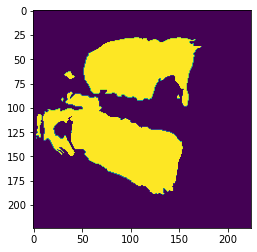

In [94]:
plt.imshow(out_cut[0].transpose(1, 2, 0))

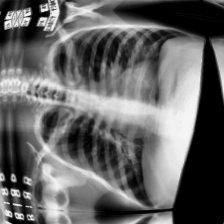

In [95]:
Image.fromarray(data_batch.data.cpu().numpy().astype(np.uint8)[0].transpose(1, 2, 0))

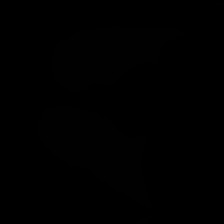

In [105]:
Image.fromarray(_.data.cpu().numpy().astype(np.uint8)[0].transpose(1, 2, 0))

In [104]:
_.data.cpu().numpy()[0]

(224, 224)

In [107]:
!pip install gdown

^C
ERROR: Operation cancelled by user


In [5]:
!gdown --folder https://drive.google.com/drive/u/0/folders/1eVAhWR8fgyu3cUNd3-3TVlLCPXsDM509

Traceback (most recent call last):
  File "/usr/local/bin/gdown", line 5, in <module>
    from gdown.cli import main
  File "/usr/local/lib/python3.5/dist-packages/gdown/__init__.py", line 8, in <module>
    from .download_folder import download_folder
  File "/usr/local/lib/python3.5/dist-packages/gdown/download_folder.py", line 11, in <module>
    from bs4 import BeautifulSoup
  File "/usr/lib/python3/dist-packages/bs4/__init__.py", line 30, in <module>
    from .builder import builder_registry, ParserRejectedMarkup
  File "/usr/lib/python3/dist-packages/bs4/builder/__init__.py", line 314, in <module>
    from . import _html5lib
  File "/usr/lib/python3/dist-packages/bs4/builder/_html5lib.py", line 70, in <module>
    class TreeBuilderForHtml5lib(html5lib.treebuilders._base.TreeBuilder):
AttributeError: module 'html5lib.treebuilders' has no attribute '_base'
